In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torchcox import TorchCox

import pandas as pd

In [3]:
df_tied = pd.read_csv('../data/ovarian_tied.csv')
df_tied

,tyears,d,Karn,Ascites
0,3.942466,1.0,8.0,1.0
1,3.098630,1.0,9.0,1.0
2,1.591783,1.0,10.0,1.0
3,1.027399,1.0,9.0,1.0
4,0.128767,1.0,6.0,1.0
...,...,...,...,...
603,0.605479,1.0,10.0,1.0
604,1.473974,1.0,7.0,1.0
605,2.747946,1.0,6.0,1.0
606,1.463013,1.0,10.0,1.0


In [4]:
%%time

coxmod = TorchCox.TorchCox()

tname = 'tyears'
Xnames = ['Karn', 'Ascites']
dname = 'd'

coxmod.fit(df_tied, Xnames=Xnames, tname=tname, dname=dname)

[-0.31499705  0.46309644]
CPU times: user 265 ms, sys: 3.66 ms, total: 268 ms
Wall time: 103 ms


In [5]:
coxmod.basehaz()

,time,h0,H0
0,0.024657240259862743,0.017221969,0.017221969
1,0.02739761676265909,0.017259976,0.0344819
2,0.03561695837826295,0.017404197,0.0518861
3,0.08219248033739741,0.017481998,0.0693681
4,0.0876713063124973,0.01758974,0.0869579
...,...,...,...
267,6.906848858445487,1.7841148,27.3774
268,7.041094163853033,2.6745756,30.0519
269,7.120547803885543,3.1728804,33.2248
270,7.290409766965798,4.507233,37.732


In [6]:
coxmod.predict_proba(df_tied, Xnames=Xnames, tname=tname)

array([0.43092038, 0.59763887, 0.83494393, 0.87485801, 0.96678993,
       0.69739469, 0.44778462, 0.76051058, 0.76206763, 0.63226784,
       0.9709761 , 0.64486562, 0.84256673, 0.89598729, 0.96750244,
       0.9482394 , 0.75644826, 0.64792831, 0.94737214, 0.91200857,
       0.6577946 , 0.5040086 , 0.85813253, 0.52384402, 0.65938519,
       0.93547978, 0.62573138, 0.87703343, 0.6400374 , 0.97934167,
       0.51393071, 0.65458143, 0.83289116, 0.30390492, 0.96750244,
       0.16453499, 0.27592903, 0.35366734, 0.87391202, 0.42032796,
       0.35037736, 0.3937177 , 0.87253253, 0.84994733, 0.76206763,
       0.4901021 , 0.45181829, 0.8010301 , 0.71923498, 0.93530423,
       0.30776781, 0.60472985, 0.93749273, 0.91917246, 0.97078056,
       0.16453499, 0.57116647, 0.85111767, 0.14223433, 0.6400374 ,
       0.7258525 , 0.50137499, 0.43033724, 0.68833133, 0.97685981,
       0.94847209, 0.72831543, 0.72086099, 0.91917246, 0.87253253,
       0.61547564, 0.93749273, 0.80508638, 0.4703003 , 0.94823

In [7]:
df_tied['pred'] = coxmod.predict_proba(df_tied, Xnames=Xnames, tname=tname)
df_tied

,tyears,d,Karn,Ascites,pred
0,3.942466,1.0,8.0,1.0,0.430920
1,3.098630,1.0,9.0,1.0,0.597639
2,1.591783,1.0,10.0,1.0,0.834944
3,1.027399,1.0,9.0,1.0,0.874858
4,0.128767,1.0,6.0,1.0,0.966790
...,...,...,...,...,...
603,0.605479,1.0,10.0,1.0,0.951075
604,1.473974,1.0,7.0,1.0,0.654581
605,2.747946,1.0,6.0,1.0,0.303905
606,1.463013,1.0,10.0,1.0,0.849947


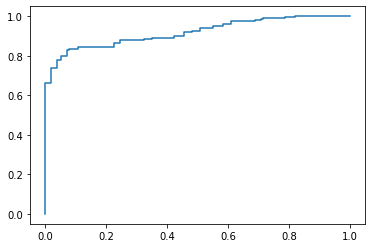

In [8]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr, tpr, thresholds = metrics.roc_curve(df_tied[dname].values, df_tied['pred'].values, pos_label=1)

plt.plot(fpr, tpr)

In [9]:
metrics.auc(fpr, tpr)

0.9181242482646688

In [10]:
#See section 5.1 of this paper for possible choices of performance metric to use:
# https://arxiv.org/pdf/2012.04284.pdf